In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import math
from scipy import signal
from skimage.filters import gabor_kernel
from scipy import ndimage as nd
import os
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from scipy.ndimage import grey_dilation as gd, rotate

In [2]:
#Fingerprint Normalization
def segmentImg(img,blockSize,threshold,display=False):
    global SMALL_VAL
    rows,cols=img.shape
    threshold=np.std(img)*threshold
    varImg=np.empty(np.shape(img))
    mask=np.ones(np.shape(img))
    for i in range(0,rows,blockSize):
        for j in range(0,cols,blockSize):
            endi=min(i+blockSize,rows)
            endj=min(j+blockSize,cols)
            varImg[i:endi, j:endj]=np.std(img[i:endi, j:endj])
    
    mask[np.where(varImg<threshold)]=0

    # smooth mask with a open/close morphological filter
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(blockSize*2, blockSize*2))
    mask = cv.morphologyEx(mask, cv.MORPH_OPEN, kernel)
    mask = cv.morphologyEx(mask, cv.MORPH_CLOSE, kernel)
    
    segmentedImg=img.copy()
    segmentedImg=np.multiply(mask,segmentedImg)    

    std=np.std(segmentedImg)
    if(std==0):
        std=SMALL_VAL
    img=(segmentedImg-np.mean(segmentedImg))/std
    meanVal=np.mean(img[np.where(mask==0)])
    stdDev=np.std(img[np.where(mask==0)])
    stdDev=np.std(img[np.where(mask==0)])
    if(stdDev==0):
        stdDev=SMALL_VAL
    normalizedImg=(img-meanVal)/stdDev
    
    
    if display:
        plt.figure(figsize=(5,5))
        plt.imshow(segmentedImg, cmap='gray')
        plt.show()

        plt.figure(figsize=(5,5))
        plt.imshow(normalizedImg, cmap='gray')
        plt.show()

    return segmentedImg, normalizedImg, mask


# img=cv.imread('../NISTSpecialDatabase4GrayScaleImagesofFIGS/sd04/png_txt/figs_0/s0007_09.png',0)         #read as grayscale
# plt.figure(figsize=(5,5))
# plt.imshow(img, cmap='gray')
# plt.show()
# segmentedImg, normalizedImg, mask=segmentImg(img,10,0.2,display=True)

In [3]:
def getOrientationField(img, blockSize, display=False):
    sobelOperator = [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]
    xSobel = np.array(sobelOperator).astype(np.int)
    ySobel = np.transpose(xSobel).astype(np.int)

    grad_x = cv.filter2D(img,-1, xSobel)
    grad_y = cv.filter2D(img,-1, ySobel)

    if(display):
        plt.figure(figsize=(5,5))
        plt.imshow(grad_x, cmap='gray')
        plt.show()

        plt.figure(figsize=(5,5))
        plt.imshow(grad_y, cmap='gray')
        plt.show()

    # find local field orientation
    rows,cols=np.shape(grad_x)
    rows1=rows//blockSize
    cols1=cols//blockSize
    vx=np.empty((rows1,cols1))
    vy=np.empty((rows1,cols1))

    for x in range(rows1):
        startx=x*blockSize
        for y in range(cols1):
            starty=y*blockSize
            gradX=grad_x[startx:startx+blockSize, starty:starty+blockSize]
            gradY=grad_y[startx:startx+blockSize, starty:starty+blockSize]
            vx[x,y]=(np.sum(2*np.multiply(gradX, gradY)))
            vy[x,y]=(np.sum(gradX**2-gradY**2))

    if(display):
        plt.figure(figsize=(5,5))
        plt.imshow(vx, cmap='gray')
        # plt.imshow(vy, cmap='gray')
        plt.show()

        plt.figure(figsize=(5,5))
        plt.imshow(vy, cmap='gray')
        plt.show()

    #theta is orientation field direction in a block
    theta=np.empty((rows1,cols1))
    for i in range(rows1):
        for j in range(cols1):
            if(vy[i,j]==0):
                theta[i,j]=0
            else:
                theta[i,j]=0.5*math.atan2(vx[i,j],vy[i,j])

    if(display):
        plt.figure(figsize=(5,5))
        plt.imshow(theta, cmap='gray')
        plt.show()
        
    return theta

In [4]:
def smoothOrientationField(theta, display=False):
    #continuous vector field
    phiX=np.empty(np.shape(theta))
    phiY=np.empty(np.shape(theta))

    phiX=np.cos(2*theta)
    phiY=np.sin(2*theta)

    h=np.ones((3,3))
    h=h/9
    fieldX=signal.convolve2d(phiX, np.rot90(h), mode='same')
    fieldY=signal.convolve2d(phiY, np.rot90(h), mode='same')

    if(display):
        plt.figure(figsize=(3,3))
        plt.imshow(fieldX, cmap='gray')
        plt.show()

        plt.figure(figsize=(3,3))
        plt.imshow(fieldY, cmap='gray')
        plt.show()
        
    smoothed=np.zeros_like(theta)
    smoothed=0.5*np.arctan2(fieldY,fieldX)

    if(display):
        plt.figure(figsize=(3,3))
        plt.imshow(smoothed, cmap='gray')
        plt.show()
        
    return smoothed

In [5]:
def findBlobs(rowList, colList, img):
    #return startpos and area of the blob which is geographically upward if 2 or less blobs are found
    #else return number of blobs. If no blob do nothing on return else smooth the img
    #if atleast one blob of area 4 is found, discard smaller blobs
    blobs=[]
    blobArea=[]
    points=list(zip(rowList, colList))
    points = sorted(points) 
    while(len(points)!=0):
        point=points[0]
        area=0
        temprow, tempcol=point
        while((temprow, tempcol) in points): 
            area+=1
            points.remove((temprow,tempcol))
            while((temprow,tempcol+1) in points):
                area+=1
                points.remove((temprow,tempcol+1))
                tempcol+=1

            tempcol=point[1]
            temprow+=1
            
        blobs.append((area, point[0], point[1]))
        blobArea.append(area)
        
    return blobs, np.array(blobArea)

In [6]:
def findPoincareVal(smoothed, i, j):
    global cells
    angles=[math.degrees(smoothed[i-m][j-n])%180 for m,n in cells]
    poincare=0
    for k in range(0,8):
        smallDelta=angles[k+1]-angles[k]
        if(smallDelta<90 and smallDelta>-90):
            poincare+=smallDelta
        elif(smallDelta<=-90):
            poincare+=(180+smallDelta)
        else:
            poincare+=(smallDelta-180)
    return poincare

def getCorePoint(normalizedImg, theta, display=False):
    global smooth, BLOCKSIZE
    rows,cols=theta.shape
    pointX=0
    pointY=0
    count=0
    A=np.empty((rows-2, cols-2))
    for i in range(1,rows-1):
        for j in range(1,cols-1):
            A[i-1,j-1]=findPoincareVal(theta, i, j)

    #normalise poincare values
    maxA=np.max(A)
    minA=np.min(A)
    if(maxA != minA):
        A=(A - minA)/(maxA - minA)
    #white corresponds to core point
    B=A[6:-6, 6:-6]

    B=np.round(B, decimals=3)

    if(display):
        plt.figure(figsize=(5,5))
        plt.imshow(A, cmap='gray')
        plt.show()

    xList=np.where((B<=1)&(B>0.66))[0]+6                   #x is the row; y is the col
    yList=np.where((B<=1)&(B>0.66))[1]+6
#     print(xList, yList)

    blobs, blobArea = findBlobs(xList,yList,B)

#     if(len(np.where(blobArea>=3)[0]<=2) or len(blobs)==1):
    if(len(blobs)==0):
        return None, None
    elif((len(np.where(blobArea>=3)[0])<=2 and len(blobs)<=5) or len(blobs)==1):
        blobs=sorted(blobs, key=lambda x: (-x[0], x[1], x[2]))
        inc=np.sqrt(blobs[0][0])/2
        pointX,pointY=blobs[0][1]+inc, blobs[0][2]+inc
    else:
        smooth=True
        return None, None

#     print(pointY, pointX)

    #get point location in original image
    coreX=pointX*BLOCKSIZE+BLOCKSIZE/2
    coreY=pointY*BLOCKSIZE+BLOCKSIZE/2

    #center is 40 pixels below core
#     centerX=coreX+40
#     centerY=coreY

    if(display):
        plt.figure(figsize=(5,5))
        plt.scatter(coreY,coreX, color='blue')
#         plt.scatter(centerY,centerX, color='red')
        plt.imshow(normalizedImg, cmap='gray')
        plt.show()
        
    return A,(coreY, coreX)

In [7]:
def getROI(normalizedImg, centerX, centerY, display=False, concCircles=6, k=8):
    '''
    returns sectorArr: array containing the sector each pixel belongs to
            roi: 140px around the center point in all directions
    '''
    rows,cols=np.shape(normalizedImg)

    startX=centerX-140
    startY=centerY-140
    endX=centerX+140
    endY=centerY+140
    if(endY>cols or endX>rows or startX<0 or startY<0):
        return None, None

    centerX=centerY=140
#     if(centerX-145>=0):
#         centerX=145
#     if(centerY-145>=0):
#         centerY=145

    roi=normalizedImg[int(startX):int(endX), int(startY):int(endY)]

    sectorTheta=[]
    sectorT=[]
    b=20     #distance between concentric circles around the center

    for sector in range(k):
        th_i=(sector%k)*2*180/k
        sectorTheta.append(th_i)

    sectorTheta.append(360)

    for sector in range(concCircles+1):
        sectorT.append(b*(sector+1))

    center=np.array([centerX,centerY])
    rows, cols=np.shape(roi)
    sectorArr=np.empty(np.shape(roi))
    sectorArr.fill(-1)

    for row in range(0,rows):
        for col in range(0,cols):
            curPoint=np.array([row,col])
            r=np.linalg.norm(curPoint-center)
            th=np.arctan2(-centerX+row,-centerY+col)
            th = math.fmod((th * (180 / math.pi)) + 360, 360)
            foundv1=False
            foundv2=False

            for i in range(0,concCircles):
                if(foundv1==False and r>=sectorT[i] and r<sectorT[i+1]):
                    foundv1=True
                    v1=i
                    break
            for i in range(0,k):
                if(foundv2==False and th>=sectorTheta[i] and th<sectorTheta[i+1]):
                    foundv2=True
                    v2=i
                    break

            if(foundv1==True and foundv2==True):
                sectorArr[row,col]=v1*k+v2
    
    if(display):
        roi[np.where(sectorArr==-1)]=0
        figure=plt.figure(figsize=(5,5))
        for i in range(1,8):
            circle1 = plt.Circle((centerY, centerX), 20*i ,fill = False, color='cyan', linewidth=2)
            plt.gca().add_patch(circle1)

        for theta in sectorTheta:
            x = 140 * np.cos(theta/180*np.pi)
            y = 140 * np.sin(theta/180*np.pi)
            plt.plot([140,140+x], [140,140+y], color='cyan')
        plt.scatter(centerY, centerX, color='red')
        plt.scatter(centerY, centerX-40, color='red')
        plt.imshow(roi, cmap='gray')
        plt.show()

    return roi, sectorArr

In [8]:
def normalizeImg(img, desiredMean=100, desiredVar=100):
    #img is a numpy array (1D in this case)
    SMALL_VAL=0.00001
    meanVal=np.mean(img)
    varVal=np.var(img)
    if(varVal==0):
        varVal=SMALL_VAL
    out=np.empty(np.shape(img))
    out[np.where(img>=meanVal)]=desiredMean+np.sqrt(desiredVar*(img[np.where(img>=meanVal)]-meanVal)**2/varVal)
    out[np.where(img<meanVal)]=desiredMean-np.sqrt(desiredVar*(img[np.where(img<meanVal)]-meanVal)**2/varVal)
    return out

In [9]:
def projectOrthogonally(block, orientation, minWavelength=5, maxWavelength=15):

    freqBlock=np.empty(np.shape(block))

    cosOrient=np.cos(2*orientation)
    sinOrient=np.sin(2*orientation)
    meanOrient=0.5*math.atan2(sinOrient, cosOrient)
    meanOrientDeg=meanOrient*180/np.pi
    
    projectedBlock=rotate(block, meanOrientDeg+90, axes=(1,0), reshape=False, mode='nearest')
    
    #sum of pixel values along the ridges (which are vertical now)
    projSum=np.sum(projectedBlock, axis=0)
    
    #grey-dilation: maximum filter over a sliding window - will give local maximum
    localMax=gd(projSum, 5, structure=np.ones(5))
    
    #diff between local maxima and cur value < threshold then maxima
    noiseThresh=2
    diff=np.abs(projSum-localMax)
    maximaInd=np.where((projSum>np.mean(projSum)) & (diff<noiseThresh))[0]
    numPeaks=len(maximaInd)
    if(numPeaks<=1):
        freqBlock.fill(0)
    else:
        wavelength=(maximaInd[-1]-maximaInd[0])/(numPeaks-1)
        if(wavelength<minWavelength or wavelength>maxWavelength):
            freqBlock.fill(0)
        else:
            freqBlock.fill(1.0/wavelength)
    return freqBlock

In [10]:
def getFreqMap(normalizedImg, smoothed, blockSize, mask):
    freqMap=np.empty(np.shape(normalizedImg))
    rows, cols=np.shape(normalizedImg)

    for row in range(0, rows-blockSize, blockSize):
        for col in range(0, cols-blockSize, blockSize):
            #blockOrientation is the local ridge orientation
            blockOrientation=smoothed[row//blockSize, col//blockSize]
            freqMap[row:row+blockSize, col:col+blockSize]=projectOrthogonally(normalizedImg[row:row+blockSize, col:col+blockSize], blockOrientation)
    
    freqMap=freqMap*mask
    freqMap=freqMap.reshape(-1)
    return freqMap

In [11]:
def getGaborFilters(medianFreq, blockSize, display=False, kx=0.5, ky=0.5):
    #check sigma_x=medianFreq*kx
    sigma_x=1.0/medianFreq*kx
    sigma_y=1.0/medianFreq*ky
    block_size = np.round(3*sigma_x)
    numFilters=4

    kernelSize=int(block_size*2+1)
#     sigma=2.5
    sigma=1.0/medianFreq*kx
    lamda=1/medianFreq
    gamma=1
    phi=0.1
    gaborFilters=[]
    for mul in range(0,numFilters):
        theta=np.pi/numFilters*mul+np.pi/2  #horizontal
#         print(180/numFilters*mul)
        kernel=cv.getGaborKernel((kernelSize, kernelSize), sigma, theta, lamda, gamma, phi)
        if(display):
            plt.figure(figsize=(3,3))
            plt.imshow(kernel, cmap='gray')
            plt.show()
        gaborFilters.append(kernel)

    return gaborFilters

In [12]:
def compute_feats(image, kernels, display=False):
    compImgs=[]
    feats = np.zeros((len(kernels), 2), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = nd.convolve(image, kernel)
        
        if display:
            plt.figure(figsize=(5,5))
            plt.imshow(filtered, cmap='gray')
            plt.show()
        compImgs.append(filtered)
    return compImgs

In [13]:
def computeF(compImg, sectorArr, numSectors):
    #return numSectors(48 in this code) values
    featVec=np.array([])
    for sector in range(numSectors):
        indices=np.where(sectorArr==sector)
        var=np.sum((compImg[indices]-np.mean(compImg[indices]))**2)
        std=np.sqrt(var)
        featVec=np.append(featVec, std)
    return featVec

# Loading Data

In [14]:
import os
import cv2 as cv
path = '../NISTSpecialDatabase4GrayScaleImagesofFIGS/sd04/png_txt/'


labels = []

def load_images_from_folder(folder):
    images = []
    for each in os.listdir(folder):
        for filename in os.listdir(os.path.join(folder,each)):
            img = cv.imread(os.path.join(folder,each,filename),0)
            if img is not None:
                images.append(img)
            else:
                f = open(os.path.join(folder,each,filename), "r", encoding='utf-8')
                try:
                    Class = ((f.read().splitlines())[1])[-1]
                    labels.append(Class)
                except:
                    pass
    return images

fingerprints = load_images_from_folder(path)

# Preprocessing Data

In [15]:
idx_labels = list(set(labels))

for i in range(len(labels)):
    labels[i] = idx_labels.index(labels[i])
labels = np.array(labels)

# Handler Function

In [16]:
failedCount = 0
failedImgs = []
errorMsgs=[]

BLOCKSIZE=16
cells = [(-1, -1), (-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1), (0, -1), (-1, -1)]
SMALL_VAL=0.00001
concCircles=6
k=8      #number of sectors in each circle
desiredMean=100
desiredVar=100
smooth = False

def handler(img, imgPath=None, display=False):
    global failedCount
    global failedImgs
    global smooth
    global errorMsgs
    global BLOCKSIZE

    #imageName=imgPath.split('/')[-1].split('.')[0]

    segmentedImg, normalizedImg, mask = segmentImg(img, BLOCKSIZE, 0.1, display)

    theta = getOrientationField(normalizedImg, BLOCKSIZE, display)

    smooth=False
    countSmooth=0
    A, core = getCorePoint(normalizedImg, theta, display)
    print(core)

    while(smooth==True and countSmooth<3):
        smooth=False
        countSmooth+=1
        theta = smoothOrientationField(theta, display)
        A, core = getCorePoint(normalizedImg, theta, display)
        print(core)
        
#     if(smooth==True or core is None):
    if(core==None):
        failedCount+=1
        failedImgs.append(imgPath)
        errorMsgs.append('-1')           #unable to find core
        return None
    
    coreY, coreX = core[0], core[1]

#     saveImage1=normalizedImg.copy()
#     saveImage1=cv.circle(saveImage1, (int(coreY),int(coreX)), radius=5, color=(0,255,0), thickness=-1)
#     plt.imsave('output/'+imageName+'_1.png', saveImage1)
#     plt.imsave('output/'+imageName+'_2.png', cv.resize(A,(512,512)))

    #center is 40 pixels below core
    centerX=coreX+40
    centerY=coreY

    roi, sectorArr = getROI(normalizedImg, centerX, centerY, display)
    if(sectorArr is None):
        failedCount+=1
        failedImgs.append(imgPath)
        errorMsgs.append('-2')         #corepoint doesn't have 140px space around it in atleast one direction
        return None

    tempArr=roi.copy()

    #normalize each sector
    numSectors=concCircles*k
    for sector in range(numSectors):
        indices=np.where(sectorArr==sector)
        tempArr[indices]=normalizeImg(tempArr[indices], desiredMean, desiredVar)

    if(display):
        plt.figure(figsize=(5,5))
        plt.imshow(tempArr, cmap='gray')
        plt.show()

    #Get freq of each block
    freqMap = getFreqMap(normalizedImg, theta, BLOCKSIZE, mask)
    posFreqInd = np.where(freqMap>0)[0]
    posFreq=freqMap[posFreqInd]
    medianFreq=np.median(posFreq)

    #apply 4 gabor kernels to the image oriented at 0, 45, 90 and 135 deg
    
    #get kernels
    if(medianFreq != 0):
        kernels=getGaborFilters(medianFreq, BLOCKSIZE, display)
    else:
        failedCount+=1
        failedImgs.append(imgPath)
        errorMsgs.append('-3')         #medianfreq is 0        
        return None
    
    #apply to the image
    compImgs=compute_feats(tempArr,kernels,display)    
    
    #get feature vector
    featureVector=np.array([])
    for i in range(len(compImgs)):
        featVec=computeF(compImgs[i], sectorArr, numSectors)
        featureVector=np.concatenate((featureVector, featVec))    
    
    return featureVector

In [17]:
#print(y_train[8])

print(len(fingerprints))

rawImages = []
classes = []
failedCount = 0

for i in range(len(fingerprints)):
    featVec = handler(fingerprints[i], display=False)
    if featVec is None:
        failedCount+=1
        print("Discarded",i)
        continue
    
    print("Done...",i)
    rawImages.append(featVec)
    classes.append(labels[i])
    
rawImages = np.array(rawImages)
classes = np.array(classes)

print("Number of images discarded from dataset: ", failedCount)
print("***RAW IMAGES***")
print(rawImages[:10])

X_train, X_test, y_train, y_test = train_test_split(rawImages, classes, test_size=0.2, random_state=42)

None
Discarded 3904
(248.0, 184.0)
Done... 3905
(147.31370849898477, 227.31370849898477)
Done... 3906
None
Discarded 3907
(200.0, 184.0)
Done... 3908
(280.0, 168.0)
Done... 3909
None
Discarded 3910
(232.0, 216.0)
Done... 3911
(328.0, 264.0)
Done... 3912
(232.0, 136.0)
Done... 3913
(312.0, 184.0)
Done... 3914
None
Discarded 3915
(264.0, 200.0)
Done... 3916
None
Discarded 3917
(235.59591794226543, 235.59591794226543)
Done... 3918
None
Discarded 3919
None
None
Discarded 3920
None
(251.59591794226543, 171.59591794226543)
Done... 3921
(131.31370849898477, 179.31370849898477)
Discarded 3922
(245.30817386124556, 245.30817386124556)
Done... 3923
None
Discarded 3924
(232.0, 184.0)
Done... 3925
None
Discarded 3926
None
Discarded 3927
(248.0, 216.0)
Done... 3928
(232.0, 216.0)
Done... 3929
None
(264.0, 168.0)
Done... 3930
(339.31370849898474, 195.31370849898477)
Done... 3931
None
Discarded 3932
(243.9428454762872, 243.9428454762872)
Done... 3933
(248.0, 216.0)
Done... 3934
(291.31370849898474, 27

In [18]:
import pickle

with open('X_train.pickle','wb') as fe_data_file:
     pickle.dump(X_train, fe_data_file)
        
with open('y_train.pickle','wb') as fe_data_file:
     pickle.dump(y_train, fe_data_file)
        
with open('X_test.pickle','wb') as fe_data_file:
     pickle.dump(X_test, fe_data_file)
        
with open('y_test.pickle','wb') as fe_data_file:
     pickle.dump(y_test, fe_data_file)

In [19]:
import pickle

with open('X_train.pickle','rb') as fe_data_file:
     X_train = pickle.load(fe_data_file)

with open('y_train.pickle','rb') as fe_data_file:
     y_train = pickle.load(fe_data_file)
        
with open('X_test.pickle','rb') as fe_data_file:
     X_test = pickle.load(fe_data_file)
        
with open('y_test.pickle','rb') as fe_data_file:
     y_test = pickle.load(fe_data_file)

# Classification

### K-Nearest Neighbours Classifier

In [37]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=150)
neigh.fit(X_train,y_train)
accuracy = neigh.score(X_test,y_test)

In [38]:
predicted = neigh.predict([X_test[0]])

print(predicted,accuracy)

prob_classes = neigh.predict_proba(X_test)
two_classes = []

idx=0
for i in prob_classes:
    l = np.argsort(i)
    max_idx = l[-1]
    second_max_idx = l[-2]
    
    two_classes.append([[X_test[idx],y_test[idx]],[max_idx, second_max_idx]])
    idx+=1

#print(two_classes)

# from sklearn.neighbors import NearestNeighbors
# neigh = NearestNeighbors(n_neighbors=2)
# neigh.fit(X_train)
# NearestNeighbors(n_neighbors=2)
# print(neigh.kneighbors(X_train))

[3] 0.39593908629441626


In [22]:
print(idx_labels)

['W', 'R', 'L', 'T', 'A']


### Neural Network based Binary Classification

#### 10 different neural networks for 10 different pairwise classifications

In [39]:
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

WA_Classifier = ['W','A']
X_train_WA = []
X_test_WA = []
y_train_WA = []
y_test_WA = []

WR_Classifier = ['W','R']
X_train_WR = []
X_test_WR = []
y_train_WR = []
y_test_WR = []

WT_Classifier = ['W','T']
X_train_WT = []
X_test_WT = []
y_train_WT = []
y_test_WT = []

WL_Classifier = ['W','L']
X_train_WL = []
X_test_WL = []
y_train_WL = []
y_test_WL = []

AR_Classifier = ['A','R']
X_train_AR = []
X_test_AR = []
y_train_AR = []
y_test_AR = []

AT_Classifier = ['A','T']
X_train_AT = []
X_test_AT = []
y_train_AT = []
y_test_AT = []

AL_Classifier = ['A','L']
X_train_AL = []
X_test_AL = []
y_train_AL = []
y_test_AL = []

RT_Classifier = ['R','T']
X_train_RT = []
X_test_RT = []
y_train_RT = []
y_test_RT = []

RL_Classifier = ['R','L']
X_train_RL = []
X_test_RL = []
y_train_RL = []
y_test_RL = []

TL_Classifier = ['T','L']
X_train_TL = []
X_test_TL = []
y_train_TL = []
y_test_TL = []

i=0

# ['W', 'A', 'R', 'T', 'L']

for x,y in zip(X_train,y_train):
    if y==0 or y==1:
        X_train_WA.append(x)
        y_train_WA.append(y)
    
    if y==0 or y==2:
        X_train_WR.append(x)
        y_train_WR.append(y)
    
    if y==0 or y==3:
        X_train_WT.append(x)
        y_train_WT.append(y)
        
    if y==0 or y==4:
        X_train_WL.append(x)
        y_train_WL.append(y)
        
    if y==1 or y==2:
        X_train_AR.append(x)
        y_train_AR.append(y)
        
    if y==1 or y==3:
        X_train_AT.append(x)
        y_train_AT.append(y)
        
    if y==1 or y==4:
        X_train_AL.append(x)
        y_train_AL.append(y)
        
    if y==2 or y==3:
        X_train_RT.append(x)
        y_train_RT.append(y)
        
    if y==2 or y==4:
        X_train_RL.append(x)
        y_train_RL.append(y)
        
    if y==3 or y==4:
        X_train_TL.append(x)
        y_train_TL.append(y)        


#['W', 'A', 'R', 'T', 'L']

for test,classes in two_classes:
    if set(classes) == set([0,1]):
        X_test_WA.append(test[0])
        y_test_WA.append(test[1])
        
    if set(classes) == set([0,2]):
        X_test_WR.append(test[0])
        y_test_WR.append(test[1])
    
    if set(classes) == set([0,3]):
        X_test_WT.append(test[0])
        y_test_WT.append(test[1])
        
    if set(classes) == set([0,4]):
        X_test_WL.append(test[0])
        y_test_WL.append(test[1])
        
    if set(classes) == set([1,2]):
        X_test_AR.append(test[0])
        y_test_AR.append(test[1])
        
    if set(classes) == set([1,3]):
        X_test_AT.append(test[0])
        y_test_AT.append(test[1])
        
    if set(classes) == set([1,4]):
        X_test_AL.append(test[0])
        y_test_AL.append(test[1])
        
    if set(classes) == set([2,3]):
        X_test_RT.append(test[0])
        y_test_RT.append(test[1])
    
    if set(classes) == set([2,4]):
        X_test_RL.append(test[0])
        y_test_RL.append(test[1])
        
    if set(classes) == set([3,4]):
        X_test_TL.append(test[0])
        y_test_TL.append(test[1])

In [40]:
def train_model(X_train):
    model = Sequential()
    model.add(Dense(20, activation = 'relu', input_shape = X_train.shape[1:]))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics = ['accuracy'])
    
    return model

In [ ]:
true_WA = true_WR = true_WT = true_WL = true_AR = true_AT = true_AL = true_RT = true_RL = true_TL = []
prediction_WA = prediction_WR = prediction_WT = prediction_WL = prediction_AR = prediction_AT = prediction_AL = prediction_RT = prediction_RL = prediction_TL = []

# WA_Classifier
X_train_WA = np.array(X_train_WA)
y_train_WA = np.array(y_train_WA)
X_test_WA = np.array(X_test_WA)
model = train_model(X_train_WA)
print(X_train_WA.shape,y_train_WA.shape)
X_train_WA.shape[1:]
model.fit(X_train_WA, y_train_WA, epochs=10)

if len(X_test_WA)>0:
    y_pred = model.predict(X_test_WA)
    y_classes = [np.argmax(element) for element in y_pred]
    prediction_WA = [WA_Classifier[i] for i in y_classes]
    true_WA = [idx_labels[i] for i in y_test_WA]


# WR_Classifier
X_train_WR = np.array(X_train_WR)
y_train_WR = np.array(y_train_WR)
X_test_WR = np.array(X_test_WR)
model = train_model(X_train_WR)
model.fit(X_train_WR, y_train_WR, epochs=10)

if len(X_test_WR)>0:
    y_pred = model.predict(X_test_WR)
    y_classes = [np.argmax(element) for element in y_pred]
    prediction_WR = [WR_Classifier[i] for i in y_classes]
    true_WR = [idx_labels[i] for i in y_test_WR]


# WT_Classifier
X_train_WT = np.array(X_train_WT)
y_train_WT = np.array(y_train_WT)
X_test_WT = np.array(X_test_WT)
model = train_model(X_train_WT)
model.fit(X_train_WT, y_train_WT, epochs=10)

if len(X_test_WT)>0:
    y_pred = model.predict(X_test_WT)
    y_classes = [np.argmax(element) for element in y_pred]
    prediction_WT = [WT_Classifier[i] for i in y_classes]
    true_WT = [idx_labels[i] for i in y_test_WT]


# WL_Classifier
X_train_WL = np.array(X_train_WL)
y_train_WL = np.array(y_train_WL)
X_test_WL = np.array(X_test_WL)
model = train_model(X_train_WL)
model.fit(X_train_WL, y_train_WL, epochs=10)

if len(X_test_WL)>0:
    y_pred = model.predict(X_test_WL)
    y_classes = [np.argmax(element) for element in y_pred]
    prediction_WL = [WL_Classifier[i] for i in y_classes]
    true_WL = [idx_labels[i] for i in y_test_WL]


# AR_Classifier
X_train_AR = np.array(X_train_AR)
y_train_AR = np.array(y_train_AR)
X_test_AR = np.array(X_test_AR)
model = train_model(X_train_AR)
model.fit(X_train_AR, y_train_AR, epochs=10)


if len(X_test_AR)>0:
    y_pred = model.predict(X_test_AR)
    y_classes = [np.argmax(element) for element in y_pred]
    prediction_AR = [AR_Classifier[i] for i in y_classes]
    true_AR = [idx_labels[i] for i in y_test_AR]


# AT_Classifier
X_train_AT = np.array(X_train_AT)
y_train_AT = np.array(y_train_AT)
X_test_AT = np.array(X_test_AT)
model = train_model(X_train_AT)
model.fit(X_train_AT, y_train_AT, epochs=10)

if len(X_test_AT)>0:
    y_pred = model.predict(X_test_AT)
    y_classes = [np.argmax(element) for element in y_pred]
    prediction_AT = [AT_Classifier[i] for i in y_classes]
    true_AT = [idx_labels[i] for i in y_test_AT]


# AL_Classifier
X_train_AL = np.array(X_train_AL)
y_train_AL = np.array(y_train_AL)
X_test_AL = np.array(X_test_AL)
model = train_model(X_train_AL)
model.fit(X_train_AL, y_train_AL, epochs=10)

if len(X_test_AL)>0:
    y_pred = model.predict(X_test_AL)
    y_classes = [np.argmax(element) for element in y_pred]
    prediction_AL = [AL_Classifier[i] for i in y_classes]
    true_AL = [idx_labels[i] for i in y_test_AL]


# RT_Classifier
X_train_RT = np.array(X_train_RT)
y_train_RT = np.array(y_train_RT)
X_test_RT = np.array(X_test_RT)
model = train_model(X_train_RT)
model.fit(X_train_RT, y_train_RT, epochs=10)

if len(X_test_RT)>0:
    y_pred = model.predict(X_test_RT)
    y_classes = [np.argmax(element) for element in y_pred]
    prediction_RT = [RT_Classifier[i] for i in y_classes]
    true_RT = [idx_labels[i] for i in y_test_RT]


# RL_Classifier
X_train_RL = np.array(X_train_RL)
y_train_RL = np.array(y_train_RL)
X_test_RL = np.array(X_test_RL)
model = train_model(X_train_RL)
model.fit(X_train_RL, y_train_RL, epochs=10)

if len(X_test_RL)>0:
    y_pred = model.predict(X_test_RL)
    y_classes = [np.argmax(element) for element in y_pred]
    prediction_RL = [RL_Classifier[i] for i in y_classes]
    true_RL = [idx_labels[i] for i in y_test_RL]


# TL_Classifier
X_train_TL = np.array(X_train_TL)
y_train_TL = np.array(y_train_TL)
X_test_TL = np.array(X_test_TL)
model = train_model(X_train_TL)
model.fit(X_train_TL, y_train_TL, epochs=10)

if len(X_test_TL)>0:
    y_pred = model.predict(X_test_TL)
    y_classes = [np.argmax(element) for element in y_pred]
    prediction_TL = [TL_Classifier[i] for i in y_classes]
    true_TL = [idx_labels[i] for i in y_test_TL]


Final Accuracy =  0.23688663282571912 



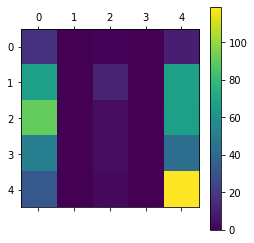

In [54]:
from sklearn.metrics import confusion_matrix, accuracy_score
import pylab as pl

prediction_classes = prediction_WA + prediction_WR + prediction_WT + prediction_WL + prediction_AR + prediction_AT + prediction_AL + prediction_RT + prediction_RL + prediction_TL

true_classes = true_WA + true_WR + true_WT + true_WL + true_AR + true_AT + true_AL + true_RT + true_RL + true_TL

# print(len(true_classes), len(prediction_classes))
# print("True Class",",", "Predicted Class")
# print("_______________________________\n")
# for i in range(len(true_classes)):
#     print((true_classes[i],prediction_classes[i]))
        
accuracy = accuracy_score(true_classes, prediction_classes)
print ("\nFinal Accuracy = ", accuracy,"\n")
cm = confusion_matrix(true_classes, prediction_classes)
pl.matshow(cm)
pl.colorbar()
pl.show()